# CS7641 Course Project: Supervised Learning

## Part 1. Fraud Detection

Welcome! For this project, I decided to work on the fraud detection of credit cards. It is one of the classical classification problems in payment industry. As a data scientist working at Mastercard, fraud is one of the top 'headache' for the cardholders, the merchants and the banks. Clearly no one likes frauds. 

However, fraud detection is a challenge problem, since the percentage of frauds among all card transactions is very small, which totally makes sense - a high fraud rate will cause significant financial damage to the card holder, banks and payment network companies. As a result, most of the fraud datasets are very imbalanced. We will get some hands on experience of modeling with imbalanced dataset. Common strategies include using up/downsampling on the training data and precision/recall as measurement of success. Because we can easily achive a high accuracy by simply predict everything as the majority class - which means nothing in this problem. 

The dataset was found in Kaggle, link provided as follows: https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud


### Environment Setup

Before we 'officially' start the ML job, let's make sure the environment is successfully set up. First, let's confirm the python version is 3.9.10 using the following code: 

In [153]:
import sys
print("Current version of Python is ", sys.version)

Current version of Python is  3.9.10 (main, Jan 15 2022, 11:48:00) 
[Clang 13.0.0 (clang-1300.0.29.3)]


After the python version is confirmed, we can install all required packages through the code below. 

In [ ]:
! pip3 install pandas==1.4.3
! pip3 install numpy==1.22.2
! pip3 install Matplotlib==3.5.3
! pip3 install sklearn
! pip3 install seaborn==0.11.2

Now let's import all required packages for further usage. 

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time

### Exploratory Data Analysis

The EDA session is the key to the success of the model development work. Before train any models, we need to understand the data, analyze the distributions, identify outliers etc. So first of all, let's load the data into memory and see what kind of information is included. 

Feature Explanation (from Kaggle):

* distancefromhome - the distance from home where the transaction happened
* distancefromlast_transaction - the distance from last transaction happened
* ratiotomedianpurchaseprice - Ratio of purchased price transaction to median purchase price
* repeat_retailer - Is the transaction happened from same retailer
* used_chip - Is the transaction through chip (credit card)
* usedpinnumber - Is the transaction happened by using PIN number
* online_order - Is the transaction an online order
* fraud - Is the transaction fraudulent

In [155]:
data = pd.read_csv("card_transdata.csv")
# data.describe()

Next step is to check the correlations between features: 

<AxesSubplot:>

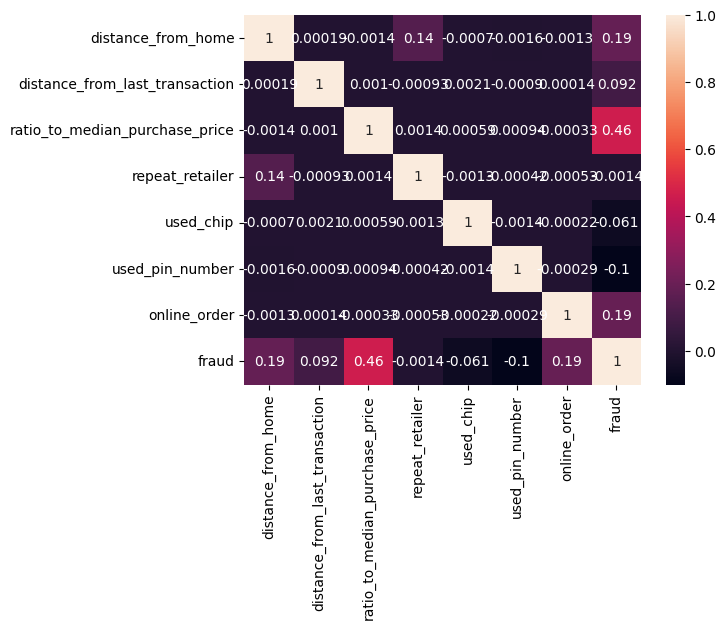

In [156]:
corr = data.corr()
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

Some highlights are:
1. We have 1,000,000 data points and 8 columns in the data
2. The label column "fraud" is imbalanced, given there are roughly 9% is frand
3. There are some extreme values existing in the numeric columns (distance_from_home, distance_from_last_transaction, ratio_to_median_purchase_price), since the max value is far different from the 75% quantile value
4. The heatmap shows the ratio_to_median_purcahse_price is highly correlated to the fraud, this makes sense since the pattern of transactions is very different from the rountine behaviour, it's very likely to be a fraud 

In [157]:
def plot_res(acc, pre, rec, t): 
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(n, acc, "-b", label="accuracy")
    ax[0].plot(n, pre, "-r", label="precision")
    ax[0].plot(n, rec, "-g", label="recall")
    ax[0].legend(loc="lower right")
    ax[1].plot(n, t, "-b", label="time")
    plt.show()

In [158]:
def f_importances(coef, names):
    imp = coef
    imp, names = zip(*sorted(zip(imp, names)))
    print("Most important feature (positive): {} {}".format(names[0], imp[0]))
    print("Most important feature (negative): {} {}".format(names[-1], imp[-1]))

### Sampling the Training Data

First, we need to split our downsampled data into training (80%) and testing (20%). A typical way of handling large imbalanced dataset is sampling. In this project, I chose to downsample the majority class to balance the label distribution before running models. We will also do some sampling on the training dadtaset to ensure the running time is feasible. The training dataset sizes in this trail are 1000, 2000, 5000, 10000. 

In [159]:
X = data[data.columns[:-1]]
y = data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   random_state=1224, 
                                   test_size=0.2, 
                                   shuffle=True)

train_dt = pd.concat([X_train, y_train], axis=1)

genuine_trans = train_dt[train_dt["fraud"]==0]
fraud_trans = train_dt[train_dt["fraud"]==1]

train_downsample = pd.concat([fraud_trans, genuine_trans.sample(n=len(fraud_trans), random_state=1224)], axis = 0)
X_train = train_downsample[train_downsample.columns[:-1]]
y_train = train_downsample['fraud']

n = [1000, 2000, 5000, 10000]
X_trains = []
y_trains = []

for s in n:
    train_sample = train_downsample.sample(n=s, random_state=1224)
    X_trains.append(train_sample[train_sample.columns[:-1]])
    y_trains.append(train_sample['fraud'])

### Model Development

#### Decision Tree

We will implement the Decision Tree algorithm with post-pruning and 5-folder cross-validation. 

For each training dataset with different size, we will train the decision tree with post-pruning. The post-pruning strategy requires a full-path model training as set up. The full-path tree is the decision tree trained without any pruning. 
Then we can start testing the pruning with different parameters using cross validation. During this process, we will use accuracy, precision, and recall score to evaluate the result. Note that with imbalanced data, accuracy is not the most important KPI as the key of success is to classify the minority class correctly. 

In [165]:
def train_decision_tree():
    test_acc_scores = []
    test_pre_scores = []
    test_rec_scores = []
    t = []
    for i in range(0, len(X_trains)): 
        X_train = X_trains[i]
        y_train = y_trains[i]
#         print("Training iteration: {} Training size: {}".format(i, X_train.shape[0]))
        
        ori_clf = DecisionTreeClassifier(random_state=1224)
        ori_clf.fit(X_train, y_train)
#         print("Depth of the full-path Decision tree: {}".format(ori_clf.tree_.max_depth))
#         print("Node count of the full-path Decision tree: {}".format(ori_clf.tree_.node_count))

        path = ori_clf.cost_complexity_pruning_path(X_train, y_train)
        ccp_alphas = path.ccp_alphas

        clfs = []
        acc_scores = []
        pre_scores = []
        rec_scores = []

        for ccp_alpha in ccp_alphas:
            clf = DecisionTreeClassifier(random_state=1224, ccp_alpha=ccp_alpha)
            scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall'])
            acc_scores.append(np.mean(scores['test_accuracy'])) 
            pre_scores.append(np.mean(scores['test_precision'])) 
            rec_scores.append(np.mean(scores['test_recall'])) 
            clfs.append(clf)

        hr_lst  = list(zip(ccp_alphas, acc_scores, pre_scores, rec_scores))
        res_df = pd.DataFrame(hr_lst, columns = ['alpha', 'accuracy', 'precision', 'recall'])
        res_df['tot'] = res_df['accuracy']+res_df['precision']+res_df['recall']
        
        best_ccp_alpha = list(res_df[res_df['tot']==res_df['tot'].max()]['alpha'])[-1]
#         print("Best alpha based on the performance: {}".format(best_ccp_alpha))
        
        start_time = time.time()
        pruned_clf = DecisionTreeClassifier(random_state=1224, ccp_alpha=best_ccp_alpha)
        pruned_clf.fit(X_train, y_train)
        t.append(time.time() - start_time)
#         print("Depth of the pruned Decision tree: {}".format(pruned_clf.tree_.max_depth))
#         print("Node count of the pruned Decision tree: {}".format(pruned_clf.tree_.node_count))
       
        y_test_pred = pruned_clf.predict(X_test)
        cf_matrix = confusion_matrix(y_test, y_test_pred)
#         print("""TP: {}     FN: {}     FP: {}      TN: {}""".format(cf_matrix[0][0], cf_matrix[0][1], 
#                                              cf_matrix[1][0], cf_matrix[1][1]))
        print("Accuracy score on test data: {:.6f}".format(accuracy_score(y_test, y_test_pred)))
#         print("Precision score on test data: {:.6f}".format(precision_score(y_test, y_test_pred)))
#         print("Recall score on test data: {:.6f}".format(recall_score(y_test, y_test_pred)))
        test_acc_scores.append(accuracy_score(y_test, y_test_pred))
        test_pre_scores.append(precision_score(y_test, y_test_pred))
        test_rec_scores.append(recall_score(y_test, y_test_pred))
    return test_acc_scores, test_pre_scores, test_rec_scores, t

In [163]:
acc, pre, rec, t = train_decision_tree()

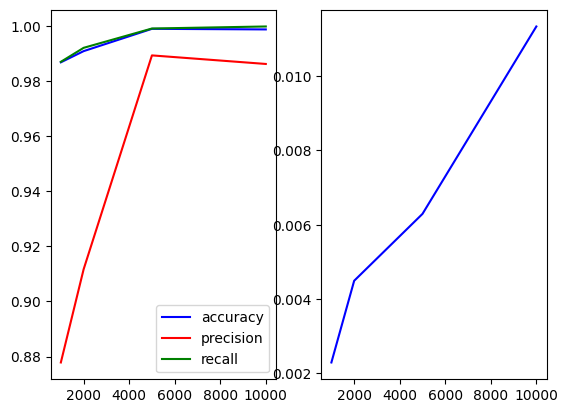

In [164]:
plot_res(acc, pre, rec, t)

In the first plot, x-axis represents training size, while y axis represents the accuracy/precision/recall, ranged between 0 to 1. The second plot shows the relationship between training size vs training time. 

Observations from the plots: 
1. Accuracy and recall seem to be "stable"; as training size increases, minor improvements are observed. 
2. The precision score increases "dramatically" from training size 2000 to 5000. From 5000 to 10000, it shows a slight decreasing trend. 
3. Running time linearly increases as training size increases. 

#### Neural Network

To experiment with different settings of neural network, we use grid search + cross-validation to test the accuracy and precision scores on the training dataset. Considering the running time, we only tested a subset of possible settings. We will use 5-folder for CV due to the long processing time of 10-folder. 

In [169]:
def train_nn():
    test_acc_scores = []
    test_pre_scores = []
    test_rec_scores = []
    t = []
    for i in range(0, len(X_trains)): 
        X_train = X_trains[i]
        y_train = y_trains[i]
#         print("Training iteration: {} Training size: {}".format(i, X_train.shape[0]))
        
        clf = MLPClassifier(hidden_layer_sizes=(5,2), 
                            activation='relu', 
                            solver='sgd',
                            alpha=0.001,
                            learning_rate='adaptive',
                            random_state=1224, 
                            max_iter=1000)

        scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall'])
        print("In sample accuracy score: {:.6f}".format(np.mean(scores['test_accuracy']))) 
#         print("In sample precision score: {:.6f}".format(np.mean(scores['test_precision']))) 
#         print("In sample recall score: {:.6f}".format(np.mean(scores['test_recall']))) 
        
        start_time = time.time()
        clf.fit(X_train, y_train)
        t.append(time.time() - start_time)
        y_test_pred = clf.predict(X_test)

        cf_matrix = confusion_matrix(y_test, y_test_pred)
#         print("""TP: {}     FN: {}      FP: {}     TN: {}""".format(cf_matrix[0][0], cf_matrix[0][1], 
#                                              cf_matrix[1][0], cf_matrix[1][1]))
        print("Accuracy score on test data: {:.6f}".format(accuracy_score(y_test, y_test_pred)))
#         print("Precision score on test data: {:.6f}".format(precision_score(y_test, y_test_pred)))
#         print("Recall score on test data: {:.6f}".format(recall_score(y_test, y_test_pred)))
        test_acc_scores.append(accuracy_score(y_test, y_test_pred))
        test_pre_scores.append(precision_score(y_test, y_test_pred))
        test_rec_scores.append(recall_score(y_test, y_test_pred))
    return test_acc_scores, test_pre_scores, test_rec_scores, t

In [167]:
acc, pre, rec, t = train_nn()

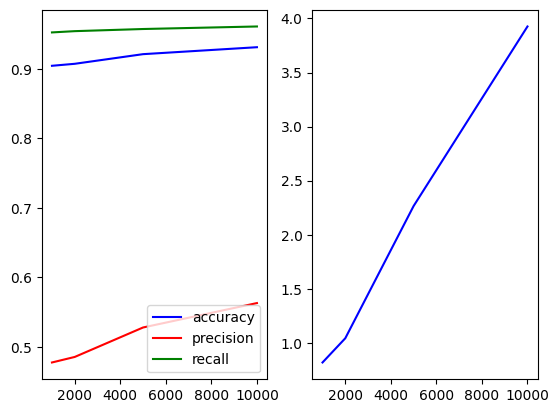

In [168]:
plot_res(acc, pre, rec, t)

In the first plot, x-axis represents training size, while y axis represents the accuracy/precision/recall, ranged between 0 to 1. The second plot shows the relationship between training size vs training time. 

Observations from the plots: 
1. Accuracy and recall seem to be "stable"; as training size increases, minor improvements are observed. 
2. There is a big gap between precision vs accuracy & recall, meaning the model tends to predict more 'frauds' than the true distribution. 
3. The precision score increases "slightly" as training size increases, keep on increasing the training size may help improve the performance. 
4. Running time linearly (almost) increases as training size increases. 

#### Boosting

We will experiment with gradient boosting tree for this work. We expand the max_depth of the tree from 3 (default) to different value as pre-pruning and used post-pruning to cut-off branches. Then we evaluate the model performance on the downsampled training data by accuracy, precision, and recall. As a result, max_depth=7 seems to be the sweet spot for this problem. Lastly, we evaluated the model on the test dataset. 

In [173]:
def train_gbc(md, alpha):
    test_acc_scores = []
    test_pre_scores = []
    test_rec_scores = []
    t = []
    for i in range(0, len(X_trains)): 
        X_train = X_trains[i]
        y_train = y_trains[i]
#         print("Training iteration: {} Training size: {}".format(i, X_train.shape[0]))
        
        clf = GradientBoostingClassifier(random_state=1224, max_depth=md, ccp_alpha=alpha)

        scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall'])
        print("In sample accuracy score: {:.6f}".format(np.mean(scores['test_accuracy']))) 
#         print("In sample precision score: {:.6f}".format(np.mean(scores['test_precision']))) 
#         print("In sample recall score: {:.6f}".format(np.mean(scores['test_recall']))) 

        start_time = time.time()
        clf.fit(X_train, y_train)
        t.append(time.time() - start_time)
        y_test_pred = clf.predict(X_test)

        cf_matrix = confusion_matrix(y_test, y_test_pred)
#         print("""TP: {}     FN: {}     FP: {}     TN: {}""".format(cf_matrix[0][0], cf_matrix[0][1], 
#                                              cf_matrix[1][0], cf_matrix[1][1]))
        print("Accuracy score on test data: {:.6f}".format(accuracy_score(y_test, y_test_pred)))
#         print("Precision score on test data: {:.6f}".format(precision_score(y_test, y_test_pred)))
#         print("Recall score on test data: {:.6f}".format(recall_score(y_test, y_test_pred)))
        test_acc_scores.append(accuracy_score(y_test, y_test_pred))
        test_pre_scores.append(precision_score(y_test, y_test_pred))
        test_rec_scores.append(recall_score(y_test, y_test_pred))
    return test_acc_scores, test_pre_scores, test_rec_scores, t

In [171]:
acc, pre, rec, t = train_gbc(md=7, alpha=0.0001)

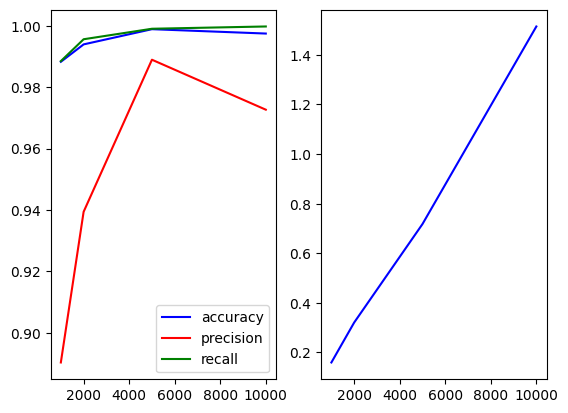

In [172]:
plot_res(acc, pre, rec, t)

The result shows that the model is well performed on both training (balanced) and testing (imbalanced). In the first plot, x-axis represents training size, while y axis represents the accuracy/precision/recall, ranged between 0 to 1. The second plot shows the relationship between training size vs training time. 

Observations from the plots: 
1. Accuracy and recall seem to be "stable"; as training size increases, minor improvements are observed. 
2. The best precision score appears at 5000 as training size; it seems to be the sweet spot, we need to keep experimenting with larger trainig size to conduct a conclusion. 
3. Running time linearly increases as training size increases. 

#### SVM


With SVM, we will experiment with different kernel - linear and rbf. 

In [180]:
def train_svc(kernel):
    test_acc_scores = []
    test_pre_scores = []
    test_rec_scores = []
    t = []
    for i in range(0, len(X_trains)): 
        X_train = X_trains[i]
        y_train = y_trains[i]
#         print("Training iteration: {} Training size: {}".format(i, X_train.shape[0]))
        clf = SVC(random_state=1224, kernel=kernel, gamma='auto', cache_size=1000, tol=1e-2)

        scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall'])
        print("In sample accuracy score: {:.6f}".format(np.mean(scores['test_accuracy']))) 
#         print("In sample precision score: {:.6f}".format(np.mean(scores['test_precision']))) 
#         print("In sample recall score: {:.6f}".format(np.mean(scores ['test_recall']))) 

        start_time = time.time()
        clf.fit(X_train, y_train)
        t.append(time.time() - start_time)
        y_test_pred = clf.predict(X_test)
        
        if kernel == "linear":
            f_importances(clf.coef_[0], list(X_train.columns))

        cf_matrix = confusion_matrix(y_test, y_test_pred)
#         print("""TP: {}     FN: {}    FP: {}     TN: {}""".format(cf_matrix[0][0], cf_matrix[0][1], 
#                                              cf_matrix[1][0], cf_matrix[1][1]))
        print("Accuracy score on test data: {:.6f}".format(accuracy_score(y_test, y_test_pred)))
#         print("Precision score on test data: {:.6f}".format(precision_score(y_test, y_test_pred)))
#         print("Recall score on test data: {:.6f}".format(recall_score(y_test, y_test_pred)))
        test_acc_scores.append(accuracy_score(y_test, y_test_pred))
        test_pre_scores.append(precision_score(y_test, y_test_pred))
        test_rec_scores.append(recall_score(y_test, y_test_pred))
    return test_acc_scores, test_pre_scores, test_rec_scores, t

In [175]:
acc, pre, rec, t = train_svc(kernel='linear')

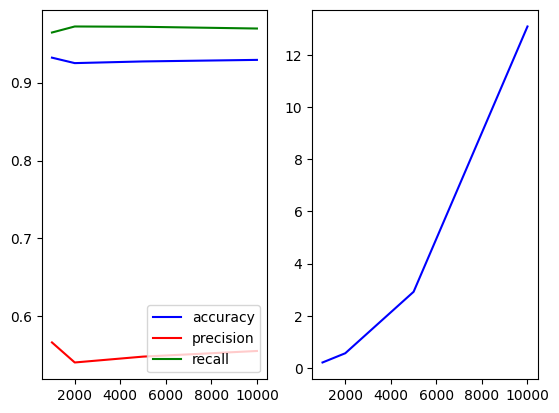

In [176]:
plot_res(acc, pre, rec, t)

The running time also increases as training size increases, but not in a linear way. 

In [177]:
acc, pre, rec, t = train_svc(kernel='rbf')

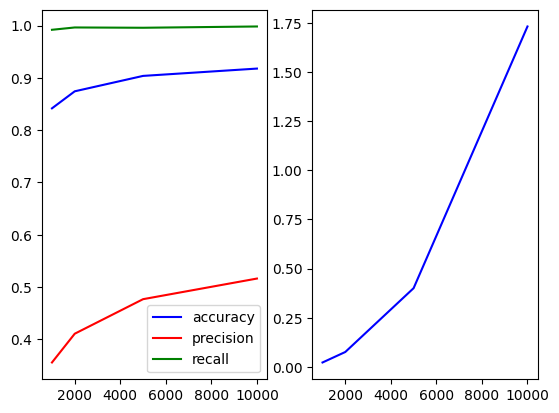

In [178]:
plot_res(acc, pre, rec, t)

Similar pattern observed as the linear kernel, while we see the precision score drops when switching from training to testing. 

The running time increases as training size increases, also in a non-linear way. 

#### KNN


Lastly, we will experiment with KNN as k=3 and 5. 

In [186]:
def train_knn(k):
    test_acc_scores = []
    test_pre_scores = []
    test_rec_scores = []
    t = []
    for i in range(0, len(X_trains)): 
        X_train = X_trains[i]
        y_train = y_trains[i]
#         print("Training iteration: {} Training size: {}".format(i, X_train.shape[0]))
        
        clf = KNeighborsClassifier(n_neighbors=k)

        scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall'])
        print("In sample accuracy score: {:.6f}".format(np.mean(scores['test_accuracy']))) 
#         print("In sample precision score: {:.6f}".format(np.mean(scores['test_precision']))) 
#         print("In sample recall score: {:.6f}".format(np.mean(scores['test_recall']))) 

        start_time = time.time()
        clf.fit(X_train, y_train)
        t.append(time.time() - start_time)
        y_test_pred = clf.predict(X_test)

        cf_matrix = confusion_matrix(y_test, y_test_pred)
#         print("""TP: {}     FN: {}     FP: {}     TN: {}""".format(cf_matrix[0][0], cf_matrix[0][1], 
#                                              cf_matrix[1][0], cf_matrix[1][1]))
        print("Accuracy score on test data: {:.6f}".format(accuracy_score(y_test, y_test_pred)))
#         print("Precision score on test data: {:.6f}".format(precision_score(y_test, y_test_pred)))
#         print("Recall score on test data: {:.6f}".format(recall_score(y_test, y_test_pred)))
        test_acc_scores.append(accuracy_score(y_test, y_test_pred))
        test_pre_scores.append(precision_score(y_test, y_test_pred))
        test_rec_scores.append(recall_score(y_test, y_test_pred))
    return test_acc_scores, test_pre_scores, test_rec_scores, t

In [182]:
acc, pre, rec, t = train_knn(k=3)

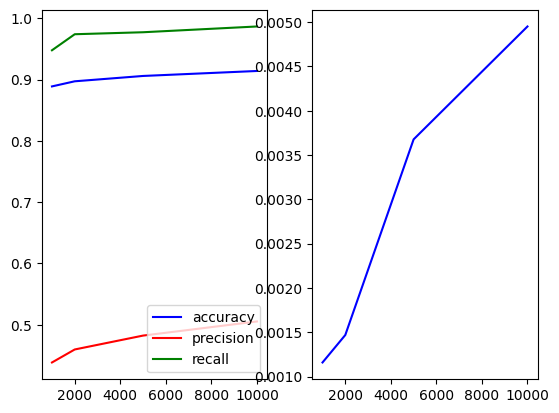

In [183]:
plot_res(acc, pre, rec, t)

In [184]:
acc, pre, rec, t = train_knn(k=5)

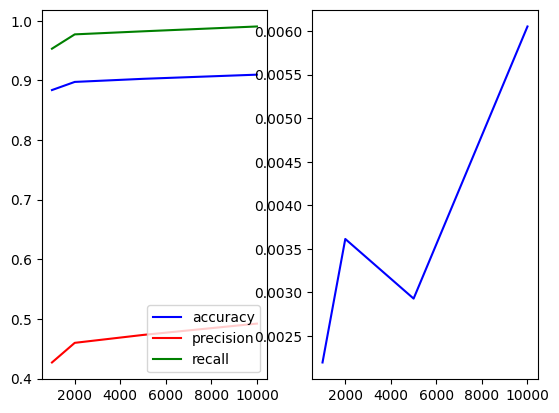

In [185]:
plot_res(acc, pre, rec, t)

The KNN performs has a better precision score on training (balanced dataset). The running time keep increasing as training size increases. 

#### Conclusion

We used accuracy, precision and recall score to define the success of the model. As a result, the Decision Tree and Gradient Boosting Classifier won the game of handling imbalanced data prediction, while Neural Network, SVM and KNN did not do a great job. This is probably because the tree model can handle non-linear relationship better than other algorithms. To improve the model performance, we did some grid search to determine the best hyperparameters for each model and experimented with different training data size. Efficiency wise, the trees and KNN are faster than SVM and Neural Network. The result may change as the hyperparameter changed. We also used cross valdiation to prevent overfitting. For each algorithm, we experimented with at least two settings of parameters. 

## Part 2. Data Science Salary

For a second trial, I experienced with the data scientist salary dataset. This is a interesting dataset that is available on Kaggle. As a wokring data scientist... Of course money matters :). I want to know which features are important to decide a data scientist' salary, maybe location? years of experience? or industry.

Link: https://www.kaggle.com/datasets/whenamancodes/data-science-fields-salary-categorization

First of all, let's read in the data first. 

In [187]:
data = pd.read_csv('Data_Science_Fields_Salary_Categorization.csv', index_col=False)
data.drop('Unnamed: 0', axis=1, inplace=True)
data['Salary_In_USD'] = data['Salary_In_Rupees'].apply(lambda x : float(x.replace(",",""))/80)
data['same_loc'] = np.where(data['Employee_Location'] == data['Company_Location'], 1, 0)

cat_lst = ['Experience', 'Employment_Status', 'Company_Location', 'Company_Size']
for c in cat_lst:
    dummy = pd.get_dummies(data[c])
    data = pd.concat([data,dummy], axis=1)

data['salary_level'] = np.where(data['Salary_In_USD'] >= 100000, 1, 0)
data.drop(cat_lst, axis=1, inplace=True)
data.drop(['Salary_In_Rupees', 'Salary_In_USD', 'Designation', 'Employee_Location'], axis=1, inplace=True)

# print(data.head())

We also transfer the amount from Rupee to USD using FX rate ~ 80. The salary mean in USD is about 111k. And so, we created the label: >100k or not, then split the data as 80% training and 20% testing. Since this data set is small, we will not experiment with different training size, but use everything for training. 

In [188]:
X = data[data.columns[:-1]]
y = data['salary_level']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   random_state=1224, 
                                   test_size=0.2, 
                                   shuffle=True)

n = [len(X_train)]
X_trains = [X_train]
y_trains = [y_train]

Now we will rerun all models as part 1 and see the performances. 

In [189]:
print("Decision Tree: ")
acc, pre, rec, t = train_decision_tree()

Decision Tree: 
Accuracy score on test data: 0.836066


In [190]:
print("Neural Network: ")
acc, pre, rec, t = train_nn()

Neural Network: 
In sample accuracy score: 0.519588
Accuracy score on test data: 0.434426


In [191]:
print("Gradient Boosting: ")
acc, pre, rec, t = train_gbc(md=7, alpha=0.)

Gradient Boosting: 
In sample accuracy score: 0.795876
Accuracy score on test data: 0.819672


In [192]:
print("SVM with linear kernel: ")
acc, pre, rec, t = train_svc(kernel='linear')

SVM with linear kernel: 
In sample accuracy score: 0.818557
Most important feature (positive): EN -1.9997670858356926
Most important feature (negative): same_loc 1.998656728325571
Accuracy score on test data: 0.852459


In [194]:
print("SVM with rbf kernel: ")
cc, pre, rec, t = train_svc(kernel='rbf')

SVM with rbf kernel: 
In sample accuracy score: 0.793814
Accuracy score on test data: 0.811475


In [195]:
print("KNN with k=3: ")
acc, pre, rec, t = train_knn(k=3)

KNN with k=3: 
In sample accuracy score: 0.740206
Accuracy score on test data: 0.762295


In [197]:
print("KNN with k=5: ")
cc, pre, rec, t = train_knn(k=5)

KNN with k=5: 
In sample accuracy score: 0.779381
Accuracy score on test data: 0.778689


Based on the result, the SVM with linear kernel is the winning model as the accuracy is the highest. As the salary is actually a continuous value, the tress might got confused when people with similar profile, but one got over 100k while the other not. The actual situation could be their salary is 99k vs 101k, which is very close. By looking at the model coefficients, the feature same_loc (meaning whether or not the employee is living in the same location as where the company located) is the most important feature, which makes sense as company is willing to pay more to people who work close to the HQ. 